In [25]:
import torch
import matplotlib.pyplot as plt

# Method

In [26]:
def create_graph_coloring_ising_hamiltonian(adj_matrix, k):
    """
    Create an Ising Hamiltonian for the graph coloring problem.
    
    Parameters:
    -----------
    adj_matrix : torch.Tensor
        Adjacency matrix of shape (n, n) where n is the number of nodes.
        adj_matrix[i, j] = 1 if nodes i and j are adjacent, 0 otherwise.
    k : int
        Number of colors.
        
    Returns:
    --------
    torch.Tensor
        Symmetric tensor representing the Ising Hamiltonian of shape (n*k, n*k).
    """
    n = adj_matrix.shape[0]
    
    # Initialize the Hamiltonian matrix
    H = torch.zeros((n*k, n*k), dtype=torch.float)
    
    # Constraint 1: Each node must have exactly one color
    # Add penalty for a node having multiple colors or no color
    for i in range(n):
        for c1 in range(k):
            idx1 = i * k + c1
            
            # Diagonal terms for one-hot constraint
            H[idx1, idx1] = -1
            
            # Cross terms to penalize multiple colors for the same node
            for c2 in range(c1+1, k):
                idx2 = i * k + c2
                H[idx1, idx2] = 2
                H[idx2, idx1] = 2
    
    # Constraint 2: Adjacent nodes cannot have the same color
    # Add penalty for adjacent nodes having the same color
    for i in range(n):
        for j in range(i+1, n):
            if adj_matrix[i, j] > 0:  # If nodes are adjacent
                for c in range(k):
                    idx_i = i * k + c
                    idx_j = j * k + c
                    
                    # Penalty for same color
                    H[idx_i, idx_j] = 2
                    H[idx_j, idx_i] = 2
    
    return H

def discrete_simulated_bifurcation(H, num_iterations=5000, alpha=0.5, dt=0.1, ballast=0.1):
    """
    Minimize energy using the Discrete Simulated Bifurcation (DSB) algorithm.
    
    Parameters:
    -----------
    H : torch.Tensor
        Hamiltonian matrix of shape (n, n).
    num_iterations : int
        Number of iterations for DSB.
    alpha : float
        Damping parameter.
    dt : float
        Time step for numerical integration.
    ballast : float
        Ballast term for stabilization.
    
    Returns:
    --------
    torch.Tensor
        Binary vector representing the solution.
    list
        List of energy values during optimization.
    """
    n = H.shape[0]
    
    # Initialize position and momentum
    x = torch.randn(n) * 0.01  # Small random initial positions
    p = torch.zeros(n)         # Initial momentum
    
    # For tracking optimization progress
    energy_history = []
    
    # DSB iterations
    for i in range(num_iterations):
        # Calculate force from Hamiltonian (gradient of energy)
        force = -torch.matmul(H, x)
        
        # Update momentum (velocity)
        p = (1 - alpha * dt) * p + force * dt
        
        # Update position
        x = x + p * dt
        
        # Apply ballast term for one-hot constraint
        for j in range(0, n, k):
            end = min(j + k, n)
            segment = x[j:end]
            ballast_force = ballast * (1 - torch.sum(segment**2))
            x[j:end] = x[j:end] * (1 + ballast_force * dt)
        
        # Calculate current energy
        energy = 0.5 * torch.matmul(x, torch.matmul(H, x))
        energy_history.append(energy.item())
        
        # Optional: Print progress
        # if (i + 1) % 100 == 0:
        #     print(f"Iteration {i+1}/{num_iterations}, Energy: {energy.item():.4f}")
    
    # Binarize the solution (convert continuous values to binary)
    x_binary = discretize_solution(x, k)
    
    return x_binary, energy_history

def discretize_solution(x, k):
    """
    Convert continuous solution to a discrete binary solution.
    For each node, select the color with the highest value.
    
    Parameters:
    -----------
    x : torch.Tensor
        Continuous solution vector of shape (n*k,).
    k : int
        Number of colors.
    
    Returns:
    --------
    torch.Tensor
        Binary vector of shape (n*k,).
    """
    n = x.shape[0] // k
    x_binary = torch.zeros_like(x)
    
    # For each node, select the color with highest value
    for i in range(n):
        start_idx = i * k
        end_idx = start_idx + k
        node_values = x[start_idx:end_idx]
        max_idx = torch.argmax(node_values) + start_idx
        x_binary[max_idx] = 1
    
    return x_binary

def calculate_energy(x, H):
    """
    Calculate the energy of a solution.
    
    Parameters:
    -----------
    x : torch.Tensor
        Binary vector of shape (n*k,).
    H : torch.Tensor
        Hamiltonian matrix of shape (n*k, n*k).
    
    Returns:
    --------
    float
        Energy value.
    """
    return 0.5 * torch.matmul(x, torch.matmul(H, x)).item()

def decode_solution(x, n, k):
    """
    Decode the solution from the binary vector.
    
    Parameters:
    -----------
    x : torch.Tensor
        Binary vector of shape (n*k,) representing the solution.
    n : int
        Number of nodes.
    k : int
        Number of colors.
        
    Returns:
    --------
    torch.Tensor
        Coloring assignment of shape (n,) where each element is the color index.
    """
    x_reshaped = x.reshape(n, k)
    colors = torch.argmax(x_reshaped, dim=1)
    return colors

def check_solution(adj_matrix, colors):
    """
    Check if the coloring is valid.
    
    Parameters:
    -----------
    adj_matrix : torch.Tensor
        Adjacency matrix of shape (n, n).
    colors : torch.Tensor
        Color assignments of shape (n,).
        
    Returns:
    --------
    bool
        True if the coloring is valid, False otherwise.
    """
    n = adj_matrix.shape[0]
    
    # Check that adjacent nodes have different colors
    for i in range(n):
        for j in range(i+1, n):
            if adj_matrix[i, j] > 0 and colors[i] == colors[j]:
                return False
    
    # Check that each node has exactly one color
    return True

def plot_energy_history(energy_history):
    """
    Plot the energy convergence during optimization.
    
    Parameters:
    -----------
    energy_history : list
        List of energy values during optimization.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(energy_history)
    plt.xlabel('Iteration')
    plt.ylabel('Energy')
    plt.title('Energy Convergence')
    plt.grid(True)
    plt.show()

def dsb_multi_start(H, n, k, adj_matrix, num_runs=50, **dsb_params):
    """
    Run DSB multiple times with different initial conditions and return the best solution.
    
    Parameters:
    -----------
    H : torch.Tensor
        Hamiltonian matrix.
    n : int
        Number of nodes.
    k : int
        Number of colors.
    adj_matrix : torch.Tensor
        Adjacency matrix.
    num_runs : int
        Number of DSB runs with different initial conditions.
    **dsb_params : dict
        Parameters for the DSB algorithm.
    
    Returns:
    --------
    torch.Tensor
        Best binary solution found.
    torch.Tensor
        Corresponding color assignments.
    float
        Energy of the best solution.
    bool
        Whether the solution is valid.
    """
    best_solution = None
    best_energy = float('inf')
    best_colors = None
    best_valid = False
    
    for run in range(num_runs):
        # print(f"\nRun {run+1}/{num_runs}")
        
        # Run DSB
        solution, energy_history = discrete_simulated_bifurcation(H, **dsb_params)
        
        # Calculate energy and decode
        energy = calculate_energy(solution, H)
        colors = decode_solution(solution, n, k)
        is_valid = check_solution(adj_matrix, colors)
        
        # print(f"Run {run+1} energy: {energy:.4f}, valid: {is_valid}")
        
        # Update best solution if better
        if (is_valid and (not best_valid or energy < best_energy)) or (not best_valid and energy < best_energy):
            best_solution = solution
            best_energy = energy
            best_colors = colors
            best_valid = is_valid
    
    return best_solution, best_colors, best_energy, best_valid

def visualize_graph_coloring(adj_matrix, colors):
    """
    Visualize the graph with the coloring solution.
    
    Parameters:
    -----------
    adj_matrix : torch.Tensor
        Adjacency matrix of shape (n, n).
    colors : torch.Tensor
        Color assignments of shape (n,).
    """
    n = adj_matrix.shape[0]
    
    # Convert to numpy for networkx
    adj_matrix_np = adj_matrix.numpy()
    colors_np = colors.numpy()
    
    # Try importing networkx
    try:
        import networkx as nx
        
        # Create graph
        G = nx.from_numpy_array(adj_matrix_np)
        
        # Define color map
        color_map = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        node_colors = [color_map[c % len(color_map)] for c in colors_np]
        
        # Draw graph
        plt.figure(figsize=(8, 8))
        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_weight='bold')
        plt.title('Graph Coloring Solution')
        plt.show()
        
    except ImportError:
        print("NetworkX not available. Install with 'pip install networkx' for visualization.")
        
        # Simple text-based visualization
        # print("\nNode coloring:")
        for i in range(n):
            print(f"Node {i}: Color {colors_np[i]}")
        
        # print("\nAdjacency:")
        for i in range(n):
            neighbors = []
            for j in range(n):
                if adj_matrix[i, j] > 0:
                    neighbors.append(j)
            # print(f"Node {i} connected to: {neighbors}")




# Problem definition


In [ ]:

# k, adj_matrix= 2, torch.tensor(
#     [[0, 1, 0, 1], # 2
#     [1, 0, 1, 0],
#     [0, 1, 0, 1],
#     [1, 0, 1, 0]]
# )


# k, adj_matrix= 6, torch.tensor(
# [[0, 1, 1, 1, 1, 0, 1, 1],
#          [1, 0, 1, 1, 1, 1, 1, 1],
#          [1, 1, 0, 1, 1, 0, 1, 0],
#          [1, 1, 1, 0, 1, 1, 1, 1],
#          [1, 1, 1, 1, 0, 1, 1, 1],
#          [0, 1, 0, 1, 1, 0, 1, 1],
#          [1, 1, 1, 1, 1, 1, 0, 1],
#          [1, 1, 0, 1, 1, 1, 1, 0]]
# )

# k, adj_matrix= 3, torch.tensor(
# [[0, 0, 1, 0, 1],
#          [0, 0, 0, 1, 1],
#          [1, 0, 0, 0, 1],
#          [0, 1, 0, 0, 1],
#          [1, 1, 1, 1, 0]]
# )

k, adj_matrix= 7, torch.tensor(
[[0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
         [1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
         [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
         [0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
         [0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
         [0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
         [0, 1, 1, 1, 1, 1, 1, 0, 1, 0]]
)

# k, adj_matrix= 3, torch.tensor(
# [[0, 0, 1, 0, 1],
#          [0, 0, 0, 1, 1],
#          [1, 0, 0, 0, 1],
#          [0, 1, 0, 0, 1],
#          [1, 1, 1, 1, 0]]
# )


# k, adj_matrix= 2, torch.tensor(
# [[0, 1, 0, 0, 1],
#          [1, 0, 0, 0, 0],
#          [0, 0, 0, 0, 0],
#          [0, 0, 0, 0, 0],
#          [1, 0, 0, 0, 0]]
# )




n = adj_matrix.shape[0]

# Run solution

Created graph with 10 nodes and 39.0 edges
Hamiltonian shape: torch.Size([70, 70])

Best solution:
Energy: 1.0000
Valid coloring: False
Colors: tensor([4, 1, 6, 5, 0, 0, 4, 4, 1, 4])


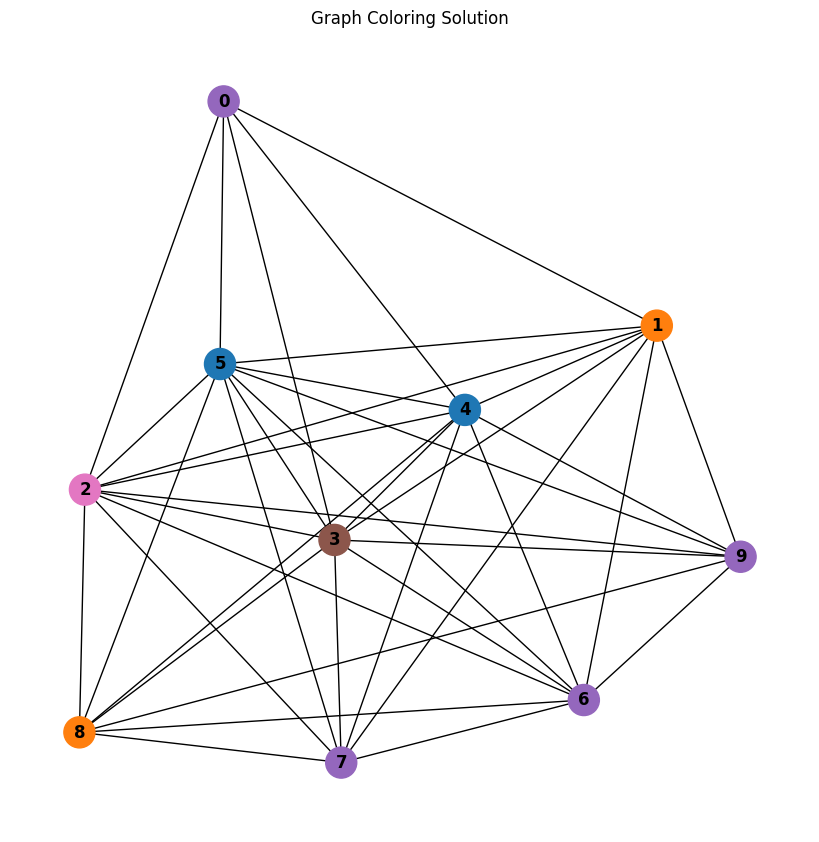

In [28]:
print("Created graph with", n, "nodes and", adj_matrix.sum().item()/2, "edges")

# Create the Hamiltonian
H = create_graph_coloring_ising_hamiltonian(adj_matrix, k)
print(f"Hamiltonian shape: {H.shape}")

# Run DSB with multiple starts
best_solution, best_colors, best_energy, is_valid = dsb_multi_start(
    H, n, k, adj_matrix,
    num_runs=5,
    num_iterations=2000,
    alpha=0.2,
    dt=0.05,
    ballast=0.5
)

print("\nBest solution:")
print(f"Energy: {best_energy:.4f}")
print(f"Valid coloring: {is_valid}")
print(f"Colors: {best_colors}")

# Visualize the result
visualize_graph_coloring(adj_matrix, best_colors)